## Architecture
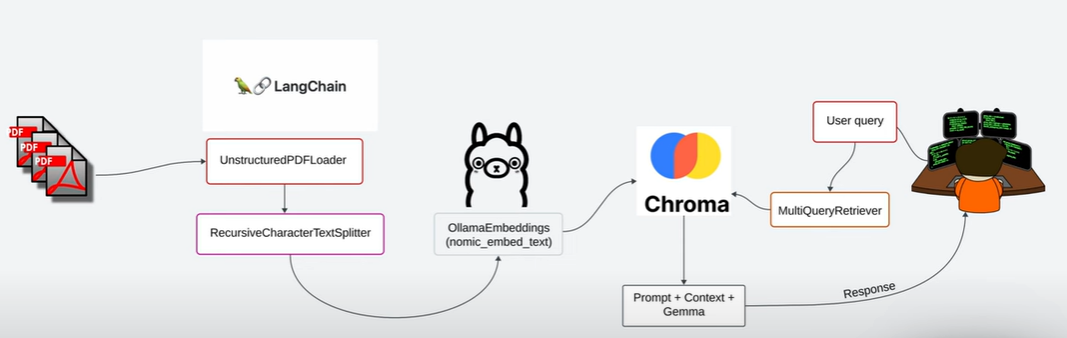

## Ingesting PDF

In [1]:
# %pip install --q unstructured langchain
# %pip install --q "unstructured[all-docs]"

In [1]:
# from langchain_community.document_loaders import UnstructuredPDFLoader
# from langchain_community.document_loaders import OnlinePDFLoader
# from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFLoader

# import nltk
# dler = nltk.downloader.Downloader()
# dler.download('punkt')
# dler.download('punkt_tab')
# dler.download('averaged_perceptron_tagger_eng')


In [2]:
local_path = "./WEF_The_Global_Cooperation_Barometer_2024.pdf"
loader = PyPDFLoader(local_path)
data = loader.load_and_split()

In [3]:
data[0].page_content

'The Global Cooperation \nBarometer 2024\nINSIGHT REPORT\nJANUARY 2024In collaboration with \nMcKinsey & Company'

## Vector Embeddings

In [5]:
# !ollama pull nomic-embed-text

In [6]:
# !ollama list

In [7]:
# %pip install --q chromadb
# %pip install --q langchain-text-splitters

In [4]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
# Split and chunk 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
chunks = text_splitter.split_documents(data)

In [7]:
# Add to vector database
embeddings = OllamaEmbeddings.embed_documents(chunks)

TypeError: embed_documents() missing 1 required positional argument: 'self'

In [ ]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

host = "http://localhost:6333"

client = QdrantClient(host)

In [ ]:
# embedding_model.get_sentence_embedding_dimension()
collection_name = "local-rag"
client.delete_collection(collection_name)

client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),

)

In [ ]:
ids = []
payload = []

for id, text in enumerate(chunks):
    ids.append(id)
    payload.append({"source": local_path, "content": text})

payload[0]

In [ ]:
client.upload_collection(
    collection_name=collection_name,
    vectors=embeddings,
    payload=payload,
    ids=ids,
    batch_size=256,  # How many vectors will be uploaded in a single request?
)

In [ ]:
client.count(collection_name)

## Retrieval

In [ ]:
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_query import MultiQueryRetriever

In [ ]:
# LLM from Ollama
local_model = "mistral"
llm = ChatOllama(model=local_model)

In [ ]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from
    a vector database. By generating multiple perspectives on the user question, your
    goal is to help the user overcome some of the limitations of the distance-based
    similarity search. Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

In [ ]:
retriever = MultiQueryRetriever.from_llm(
    vector_db.as_retriever(), 
    llm,
    prompt=QUERY_PROMPT
)

# RAG prompt
template = """Answer the question based ONLY on the following context:
{context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
chain.invoke(input(""))

In [ ]:
chain.invoke("What are the 5 pillars of global cooperation?")

In [ ]:
# Delete all collections in the db
vector_db.delete_collection()